In [1]:
from dataclasses import MISSING, fields, replace
import dataclasses as dcls
import typing
import jax
import scipy

from jax.tree_util import GetAttrKey

def _register_dataclass(nodetype, fields):
    data_fields = tuple(f.name for f in fields)

    def flatten_with_keys(x):
        data = tuple((GetAttrKey(name), getattr(x, name)) for name in data_fields)
        return data, None

    def unflatten_func(meta, data):
        kwargs = dict(zip(data_fields, data))
        return nodetype(**kwargs)

    def flatten_func(x):
        data = tuple(getattr(x, name) for name in data_fields)
        return data, None

    jax.tree_util.register_pytree_with_keys(
        nodetype, flatten_with_keys,
        unflatten_func, flatten_func
    )

@typing.dataclass_transform()
def dataclass(cls=None, frozen=True, **kwargs):
    if cls is None:
        return functools.partial(dataclass, frozen=frozen, **kwargs)
    cls = dcls.dataclass(frozen=frozen, unsafe_hash=True, **kwargs)(cls)
    fields = dcls.fields(cls)
    if frozen:
        _register_dataclass(cls, fields)
    return cls

In [2]:
class Flow: ...

@dataclass
class NormalFlow:
    mu: jax.Array
    sigma: jax.Array

    def __call__(self, x, t):
        sigma_t = jnp.sqrt(self.sigma*self.sigma*(1 - t) + t)
        sigma_t_dot = (1-self.sigma*self.sigma)/(2*sigma_t)
        mu_t = (1 - t)*self.mu
        mu_t_dot = -self.mu
        return (x - mu_t)*(sigma_t_dot/sigma_t) + mu_t_dot
    
    def log_pdf(self, x, t):
        sigma_t = jnp.sqrt(self.sigma*self.sigma*(1 - t) + t)
        mu_t = (1 - t)*self.mu
        return jax.scipy.stats.norm.logpdf(x, mu_t, sigma_t)

@dataclass
class MixtureFlow:
    components: list[Flow]
    weights: jax.Array | None = None

    def __call__(self, x, t):
        log_pdfs = jnp.array([c.log_pdf(x,t) for c in self.components])
        if self.weights is not None:
            log_pdfs = log_pdfs + jnp.log(self.weights)
        total = jax.scipy.special.logsumexp(log_pdfs)
        log_pdfs = log_pdfs - total
        weights = jnp.exp(log_pdfs)
        vs = jnp.array([c(x,t) for c in self.components])
        return jnp.sum(weights*vs)

    def log_pdf(self, x, t):
        log_pdfs = jnp.array([c.log_pdf(x,t) for c in self.components])
        if self.weights is not None:
            log_pdfs = log_pdfs + jnp.log(self.weights)
        total = jax.scipy.special.logsumexp(log_pdfs)
        log_pdfs = log_pdfs - total
        return jnp.sum(log_pdfs)

@dataclass
class LinearCombination:
    flows: list[Flow]
    alphas: jax.Array

    def __call__(self, x, t):
        vs = jnp.array([c(x,t) for c in self.flows])
        return jnp.sum(self.alphas * vs, axis=0)

In [8]:
import jax
import jax.numpy as jnp
import jax.scipy
import functools
import matplotlib.pyplot as plt

@functools.partial(jax.jit, static_argnums=(0,))
def integrate(timesteps, flow, x):
    ts = 1 - jnp.linspace(0, 1, timesteps, endpoint=False)
    dt = 1/timesteps
    # integrate back in time
    def scan_fn(x, t):
        v = flow(x, t)
        nx = x - v*dt
        return nx, nx
    result, trajectory = jax.lax.scan(scan_fn, x, ts)
    # reverse time on the trajectory
    trajectory = trajectory[::-1]
    ts = ts[::-1]
    return (ts, trajectory)

@functools.partial(jax.jit, static_argnums=(0,2))
def sample_normal(timesteps, flow, trajectory=True):
    data = jax.vmap(jax.random.normal)(jax.random.split(jax.random.key(42), 4*4*4*4*1024))
    traj = jax.vmap(integrate, in_axes=(None, None, 0))(timesteps, flow, data)
    if trajectory: return traj
    else: return traj[1][:,0]

def visualize_trajs(timesteps, flow, scaling=1, bins=100, xlim=None):
    data = jax.vmap(jax.random.normal)(jax.random.split(jax.random.key(42), 2048))
    traj = jax.vmap(integrate, in_axes=(None, None, 0))(timesteps, flow, data)
    # plt.scatter(traj[0], traj[1], alpha=0.1)
    xs = traj[0].reshape(-1)
    ys = traj[1].reshape(-1) / scaling
    _, (ax1, ax2) = plt.subplots(1, 2)
    ax1.hist2d(xs, ys, bins=[timesteps, bins])
    final = traj[1][:,0] / scaling
    if xlim is not None:
        final = final[jnp.logical_and(final >= xlim[0], final <= xlim[1])]
    ax2.hist(final, bins)

def visualize_interp(timesteps, flow_a, flow_b, num_alphas=100, bins=100, alpha_min=0, alpha_max=1, vis_alphas=None):
    alphas = jnp.linspace(alpha_min, alpha_max, num_alphas)
    alphas_distributions = jax.vmap(lambda alpha: sample_normal(timesteps, 
        LinearCombination([flow_a, flow_b], jnp.array([alpha, 1 - alpha])),
        trajectory=False
    ))(alphas)
    alphas_rep = jnp.repeat(alphas[:, None], alphas_distributions.shape[-1], -1)
    xs, ys = alphas_rep.reshape(-1), alphas_distributions.reshape(-1)
    fig, (ax1, ax2) = plt.subplots(2, 1)
    ax1.hist2d(xs, ys, bins=[num_alphas, bins])
    ax1.set_xlabel("alpha")
    ax1.set_ylabel("generated sample")
    if vis_alphas is not None:
        for alpha in vis_alphas:
            i = jnp.argmin(jnp.abs(alphas - alpha))
            dist = alphas_distributions[i]
            ax2.hist(dist, label=f"Alpha={alpha:0.2f}", bins=bins, alpha=0.6)
        # fig.legend()
    return alphas, alphas_distributions

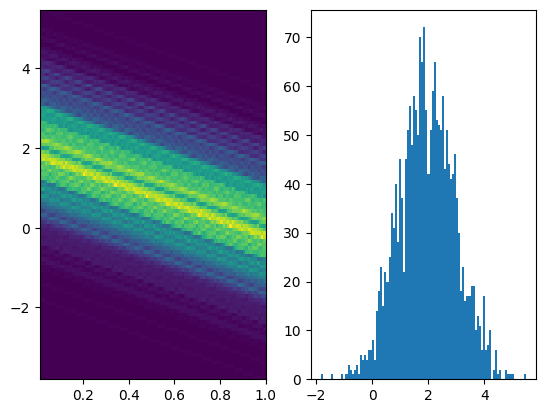

In [9]:
visualize_trajs(100, NormalFlow(2., 1.))


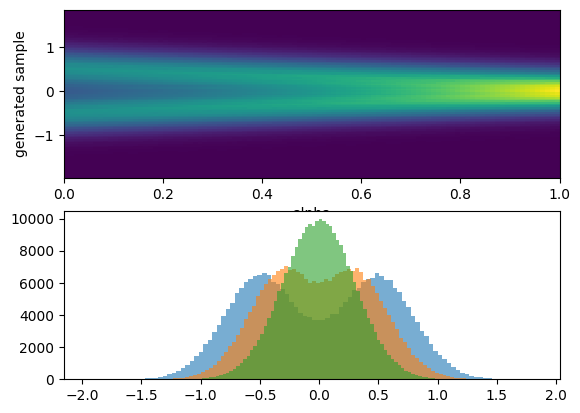

In [10]:
sigma = 0.3
mu = 0.5
_ = visualize_interp(64,
    NormalFlow(0., sigma), MixtureFlow((
        NormalFlow(-mu, sigma), NormalFlow(mu, sigma),
    )),
    vis_alphas=[0, 0.5, 1],
    alpha_min=0,
    alpha_max=1
)

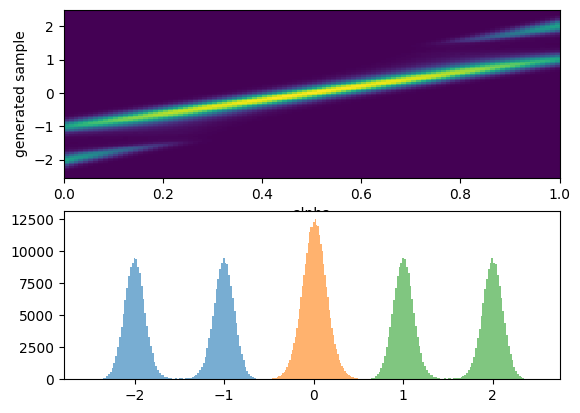

In [14]:
sigma = 0.1
alphas, alphas_dist = visualize_interp(100, MixtureFlow((
    NormalFlow(1.0, sigma), NormalFlow(2.0, sigma),
)), MixtureFlow((
    NormalFlow(-1, sigma), NormalFlow(-2, sigma)
)), vis_alphas=[0., 0.5, 1.])

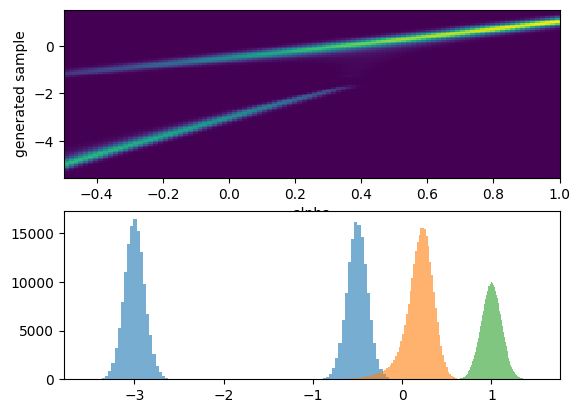

In [12]:
sigma = 0.1
alphas, alphas_dist = visualize_interp(100, NormalFlow(1.0, sigma), MixtureFlow((
    NormalFlow(-0.5, sigma), NormalFlow(-3, sigma)
)), alpha_min=-0.5, vis_alphas=[0., 0.5, 1.])


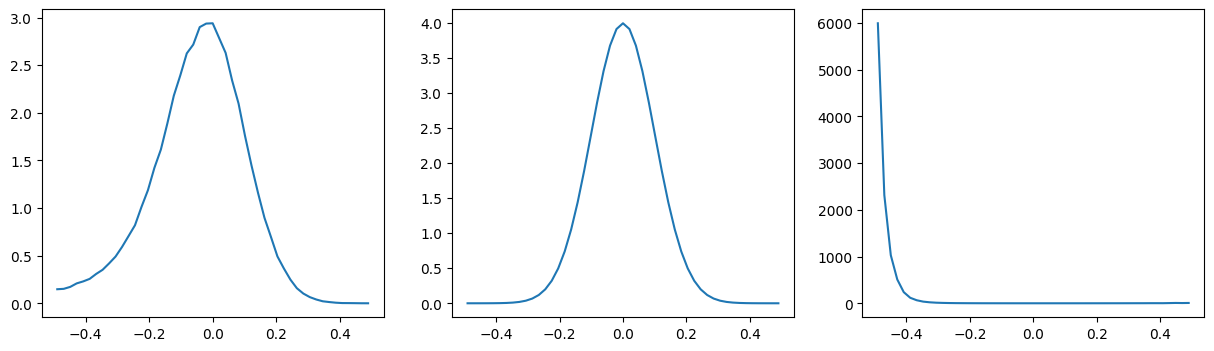

In [ ]:
target_alpha = 0.5
expected_mu = 0.5*target_alpha
expected_sigma = sigma
i = jnp.argmin(jnp.abs(alphas - target_alpha))
samples = alphas_dist[i]
res = scipy.stats.ecdf(samples)
xs = jnp.linspace(expected_mu - 0.5, expected_mu + 0.5, 50)
cdfs = res.cdf.evaluate(xs)
locs = (xs[1:] + xs[:-1])/2
pdfs = (cdfs[1:] - cdfs[:-1])/(xs[1] - xs[0])
Phi = scipy.stats.norm.pdf((locs - expected_mu)/expected_sigma)/expected_sigma
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))
ax1.plot(locs - 0.25, pdfs)
ax2.plot(locs - 0.25, Phi)
ax3.plot(locs - 0.25, pdfs/Phi)
plt.show()

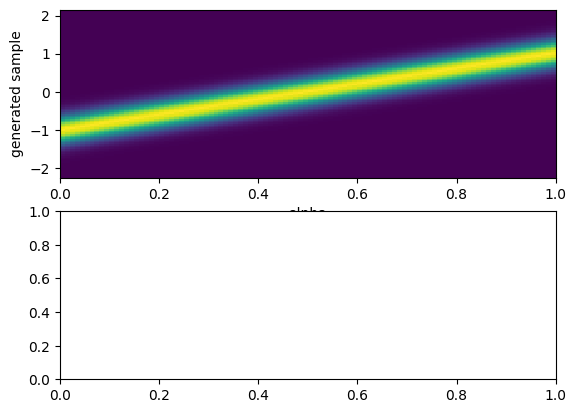

In [ ]:
sigma = 0.25
_ = visualize_interp(100, NormalFlow(1.0, sigma), NormalFlow(-1.0, sigma))